# Two-layer custom CNN from MOSAIKS

## Prepare GeoLife data loader

In [1]:
import os
import sys
import time
import inspect
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

random_state = np.random.RandomState(0)

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

trf = torch.nn.Sequential(
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
)

## Two-layer CNN MOSAIK

In [5]:
kernel_size = '7-7'
mode = ''
model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
mosaik_model_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_{kernel_size}{mode}.pt"
model.load_state_dict(torch.load(mosaik_model_path))

<All keys matched successfully>

## Custom Mosaiks

In [20]:
# model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(20736, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, num_species)
#       ) 
# model(torch.rand((1, 3, 224, 224))).shape

## slicing up the network

In [21]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=17037, bias=True)
)

In [6]:
# for 2-conv layers
conv_lyrs = [0, 3]
act_lyrs = [1, 4, 10]

# for 4-conv layers
# conv_lyrs = [0, 2, 4, 6]
# act_lyrs = [1, 4, 7, 10]

In [7]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [8]:
# for 2-conv layers
model[1].register_forward_hook(get_features('relu_layer_1'))
model[4].register_forward_hook(get_features('relu_layer_4'))
model[10].register_forward_hook(get_features('relu_layer_10'))


# for 4-conv layers (without nn.AdaptivePool layer)
# model[1].register_forward_hook(get_features('relu_layer_1'))
# model[4].register_forward_hook(get_features('relu_layer_4'))
# model[7].register_forward_hook(get_features('relu_layer_7'))
# model[10].register_forward_hook(get_features('relu_layer_10'))

In [9]:
layer_idx = 0

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

index = 0
buffer = []


curr_param_idx = conv_lyrs[layer_idx]
curr_param_sz = model[curr_param_idx].weight.data.shape # or list(model.children())[curr_param_idx].weight

print(f'current parameter size: {curr_param_sz}')

num_feats = curr_param_sz[0]
num_ch = curr_param_sz[1]
patch_size = (curr_param_sz[2], curr_param_sz[3])
max_patches = int(num_feats/2)    
    
# for _ in range(num_iters):
for batch in geo_train_loader:
    
    
    patches, target, meta = batch
#     patches['rgb'] = trf(patches['rgb'])

    output = model(patches['rgb'])

    if layer_idx == 0:
        curr_feats = patches['rgb'].numpy()
    else:
        curr_feats = features_dim[f'relu_layer_{act_lyrs[layer_idx-1]}'].numpy()


    curr_feats = curr_feats.squeeze(0)
    curr_feats = np.einsum('ijk->jki', curr_feats)

    data = extract_patches_2d(curr_feats, 
                              patch_size, 
                              max_patches=max_patches, 
                              random_state=random_state)
    
#     data -= np.mean(data, axis=0)
#     data /= np.std(data, axis=0)
    
    data = np.reshape(data, (len(data), -1))
    buffer.append(data)

current parameter size: torch.Size([64, 3, 7, 7])


In [10]:
len(buffer), buffer[0].shape

(2004, (32, 147))

In [11]:
data_pnts = np.concatenate(buffer, axis=0)
data_pnts.shape

(64128, 147)

In [12]:
random_idx = np.random.randint(data_pnts.shape[0], size=32)
random_idx

array([31289, 36015,  7518,  1737, 28620, 37076, 23225, 53973, 14245,
       41786, 40099, 60568, 27423, 34152,  5841, 46354, 19312, 51349,
       33689, 62561, 10481, 30148, 42371, 36113, 18168, 18663, 33121,
       21418, 34922, 40670, 15098, 16461])

In [13]:
data_viz = data_pnts[random_idx, :].reshape(32, 3, 7, 7)
data_viz.shape

(32, 3, 7, 7)

# visualize the patches

In [14]:
from torchvision import utils
import torch
import matplotlib.pyplot as plt

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

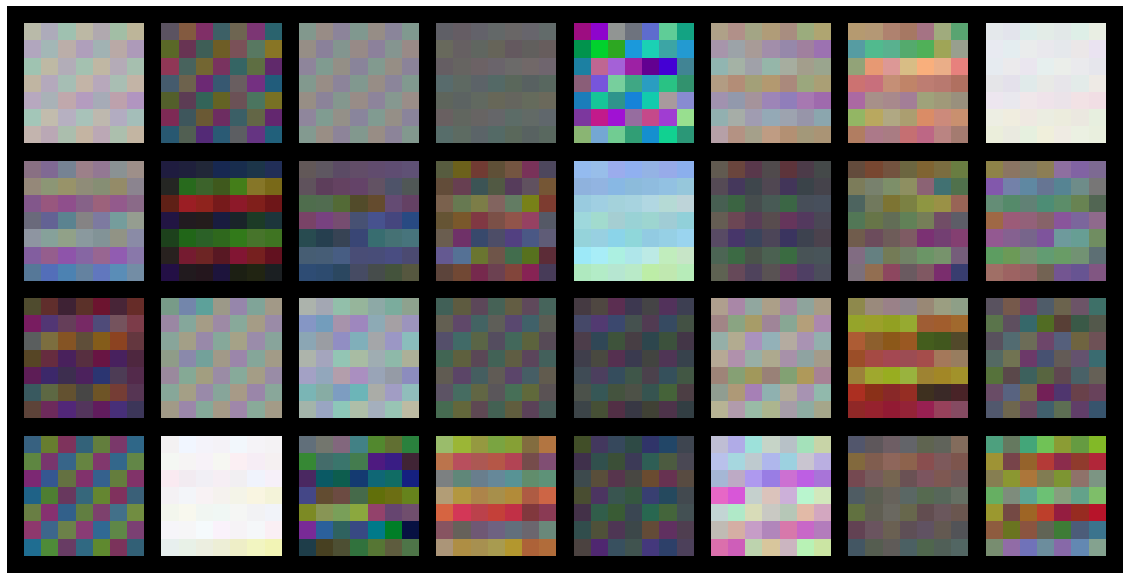

In [15]:
visTensor(torch.from_numpy(data_viz), ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
# plt.rcParams['savefig.facecolor']='white'
# plt.savefig(f'../images/mosaik_conv1_{kernel_size}_{mode}_filter_color.png')
plt.show()

In [20]:
reconstruction_errors = []

for num_clusters in range(2, 64):
    
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, 
                             random_state=random_state,
    #                          max_no_improvement=5,
    #                          tol=0.01,
    #                          max_iter=5,
    #                          batch_size = kmeans_bs,
                             verbose=False)



    data = np.concatenate(buffer, axis=0)
    kmeans.fit(data)

    # distance between the datapoints and the clusters
    data_pnts = np.concatenate(buffer, axis=0)

    cluster_distance = 0.0
    for pnt in data_pnts:
        cluster_distance += min(np.linalg.norm(pnt-kmeans.cluster_centers_, axis=1))
    cluster_distance /= len(data_pnts)
    reconstruction_errors.append(cluster_distance)

Init 1/3 with method k-means++
Inertia for init 1/3: 118678.6953125
Init 2/3 with method k-means++
Inertia for init 2/3: 118384.0703125
Init 3/3 with method k-means++
Inertia for init 3/3: 116154.59375
Minibatch step 1/6262: mean batch inertia: 39.39832305908203
Minibatch step 2/6262: mean batch inertia: 27.030996322631836, ewa inertia: 27.030996322631836
Minibatch step 3/6262: mean batch inertia: 25.785606384277344, ewa inertia: 26.99122401067079
Minibatch step 4/6262: mean batch inertia: 27.375408172607422, ewa inertia: 27.00349317382079
Minibatch step 5/6262: mean batch inertia: 24.832353591918945, ewa inertia: 26.934156464005653
Minibatch step 6/6262: mean batch inertia: 27.03997039794922, ewa inertia: 26.937535698622074
Minibatch step 7/6262: mean batch inertia: 26.252870559692383, ewa inertia: 26.915670486245023
Minibatch step 8/6262: mean batch inertia: 26.58462142944336, ewa inertia: 26.905098226139145
Minibatch step 9/6262: mean batch inertia: 25.47361183166504, ewa inertia: 2

In [50]:
reconstruction_errors

[3.2050493966942346,
 2.3654208714948752,
 2.109116294392442,
 2.034676793383661,
 1.9577483634562967,
 1.8939326045962195,
 1.8506882642669986,
 1.8141213405980523,
 1.7848499321681772,
 1.7587797527481241,
 1.7384912006930167,
 1.7012414783476377,
 1.6948496029189901,
 1.6658758151910997,
 1.6558636378324005]

In [21]:
import matplotlib.pyplot as plt

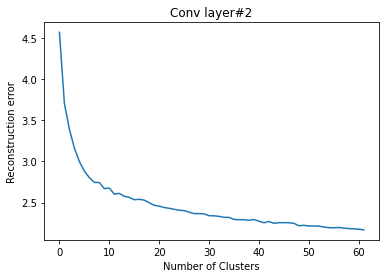

In [22]:
plt.title("Conv layer#2")
plt.xlabel("Number of Clusters")
plt.ylabel("Reconstruction error")
plt.plot(reconstruction_errors)
plt.rcParams['savefig.facecolor']='white'
plt.savefig('../images/mosaik_conv2_kmeans_reconstruction_errors.png')

plt.show()